In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, entropy

In [16]:
# Load datasets
human = pd.read_csv('../../human_experiment/newsvendor_human_data.csv')
instruction = pd.read_csv('../../results/Newsvendor/instruction.csv')
intrinsic = pd.read_csv('../../results/Newsvendor/intrinsic.csv')
imitation = pd.read_csv('../../results/Newsvendor/imitation.csv')

In [17]:
# Add mode labels
human["mode"] = "Human"
intrinsic["mode"] = "Intrinsicality"
instruction["mode"] = instruction["mode"].map({
    "risk-seeking": "Risk-Seeking",
    "risk-averse": "Risk-Averse"
})

# Helper Functions

In [18]:
def q_star(row):
    """Calculate optimal order quantity using critical ratio"""
    critical = (row["price"] - row["cost"]) / row["price"]
    return 1 + 299 * critical  # Inverse CDF for U[1,300]

def compute_profit_sales(order, demand, price, cost):
    """Calculate profit and sales given order, demand, price, and cost"""
    sales = min(order, demand)
    profit = price * sales - cost * order
    return profit, sales

def order_entropy(series):
    """Calculate entropy for order quantity series"""
    order_bins = np.round(series).astype(int)
    counts = np.bincount(order_bins[order_bins >= 0])
    probs = counts[counts > 0] / counts.sum()
    return entropy(probs, base=2)

def calculate_comprehensive_newsvendor_metrics(df, stage_name):
    """Calculate comprehensive metrics for newsvendor experiment"""
    results = []
    modes = df['mode'].unique()
    human_orders = df[df['mode'] == 'Human']['order'].values
    
    for mode in modes:
        mode_data = df[df['mode'] == mode]
        order_data = mode_data['order'].values
        
        # Basic statistics
        mean_order = order_data.mean()
        std_order = order_data.std()
        
        # Entropy calculation
        entropy_val = order_entropy(order_data)
        
        # KS distance (only for AI models, not human)
        if mode != 'Human':
            ks_distance = ks_2samp(order_data, human_orders).statistic
        else:
            ks_distance = 0.0
        
        results.append({
            'Stage': stage_name,
            'Mode': mode,
            'Mean (Std)': f"{mean_order:.2f} ({std_order:.2f})",
            'Entropy': round(entropy_val, 3),
            'KS Distance to Human': round(ks_distance, 3) if mode != 'Human' else 'N/A',
            'Count': len(order_data)
        })
    
    return pd.DataFrame(results)

# Analysis

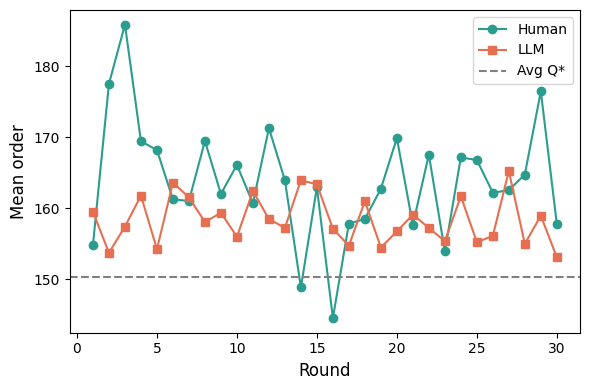

In [19]:
# Intrinsicality Analysis: Learning Curve
df_intrinsic = pd.concat([human, intrinsic], ignore_index=True)
df_intrinsic["q_star"] = df_intrinsic.apply(q_star, axis=1)
df_intrinsic["order_bias"] = df_intrinsic["order"] - df_intrinsic["q_star"]

plt.figure(figsize=(6, 4))
for mode, marker, color in [("Human", "-o", "#2A9D8F"), ("Intrinsicality", "-s", "#E76F51")]:
    learning_curve = (
        df_intrinsic[df_intrinsic["mode"] == mode]
        .groupby("round")["order"]
        .mean()
        .sort_index()
    )
    label = "LLM" if mode == "Intrinsicality" else "Human"
    plt.plot(learning_curve.index, learning_curve.values, marker, color=color, label=label)

plt.axhline(df_intrinsic["q_star"].mean(), color="gray", ls="--", label="Avg Q*")
plt.xlabel("Round", fontsize=12)
plt.ylabel("Mean order", fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig("newsvendor_human_vs_intrinsic.pdf", dpi=300)
plt.show()


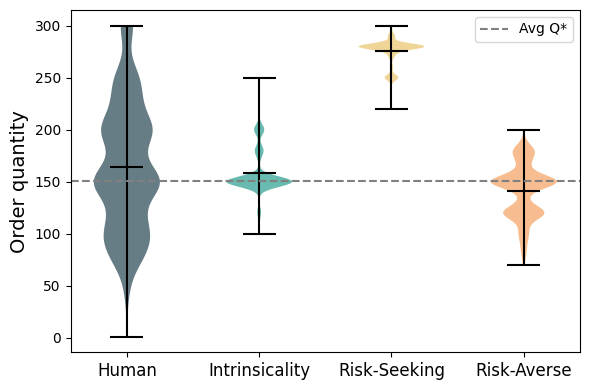

In [20]:
# Instruction Analysis: Order Distribution
df_instruction = pd.concat([human, intrinsic, instruction], ignore_index=True)
df_instruction["q_star"] = df_instruction.apply(q_star, axis=1)
df_instruction["order_bias"] = df_instruction["order"] - df_instruction["q_star"]

colors = ["#264653", "#2A9D8F", "#E9C46A", "#F4A261"]
modes = ["Human", "Intrinsicality", "Risk-Seeking", "Risk-Averse"]

plt.figure(figsize=(6, 4))
violin_parts = plt.violinplot(
    [df_instruction[df_instruction["mode"] == mode]["order"] for mode in modes],
    positions=range(4),
    showmeans=True
)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.7)

for part in ['cmeans', 'cmaxes', 'cmins', 'cbars']:
    violin_parts[part].set_color('black')

plt.xticks(range(4), modes, fontsize=12)
plt.ylabel("Order quantity", fontsize=14)
plt.axhline(df_instruction["q_star"].mean(), color="gray", ls="--", label="Avg Q*")
plt.legend()
plt.tight_layout()
plt.savefig("newsvendor_instruction_order_distribution.pdf", dpi=300)
plt.show()


# Comprehensive Metrics Analysis

In [21]:
# Prepare imitation data
imitation_clean = imitation.drop(columns=["order_human"]).rename(columns={"order_llm": "order"})
df_imitation = pd.concat([human, intrinsic, imitation_clean], ignore_index=True)
df_imitation["q_star"] = df_imitation.apply(q_star, axis=1)
df_imitation["order_bias"] = df_imitation["order"] - df_imitation["q_star"]

In [22]:
# Map mode labels for imitation data
imitation_mode_map = {
    "direct": "Direct",
    "Human": "Human",
    "Intrinsicality": "Intrinsicality"
}
df_imitation["mode"] = df_imitation["mode"].map(imitation_mode_map)

In [23]:
# Check available modes in imitation data
print("Available modes in imitation data:", df_imitation['mode'].unique())
print("Mode counts:", df_imitation['mode'].value_counts())

Available modes in imitation data: ['Human' 'Intrinsicality' 'Direct']
Mode counts: mode
Human             1200
Intrinsicality    1190
Direct             585
Name: count, dtype: int64


In [24]:
# Add profit and sales calculations for imitation data
df_imitation[["profit", "sales"]] = df_imitation.apply(
    lambda row: compute_profit_sales(row["order"], row["demand"], row["price"], row["cost"]), 
    axis=1, result_type="expand"
)

In [25]:
# Stage 1: Intrinsicality Analysis
intrinsic_results = calculate_comprehensive_newsvendor_metrics(df_intrinsic, "Intrinsicality")

In [26]:
# Stage 2: Instruction Analysis
instruction_results = calculate_comprehensive_newsvendor_metrics(df_instruction, "Instruction")

In [27]:
# Stage 3: Imitation Analysis
imitation_results = calculate_comprehensive_newsvendor_metrics(df_imitation, "Imitation")


In [28]:
# Combined Comprehensive Summary Table
all_results = pd.concat([intrinsic_results, instruction_results, imitation_results], ignore_index=True)
all_results


,Stage,Mode,Mean (Std),Entropy,KS Distance to Human,Count
0,Intrinsicality,Human,163.80 (61.25),4.555,N/A,1200
1,Intrinsicality,Intrinsicality,158.39 (20.57),1.706,0.295,1190
2,Instruction,Human,163.80 (61.25),4.555,N/A,1200
3,Instruction,Intrinsicality,158.39 (20.57),1.706,0.295,1190
4,Instruction,Risk-Averse,140.60 (25.64),3.048,0.367,1167
5,Instruction,Risk-Seeking,275.44 (11.93),1.889,0.88,1193
6,Imitation,Human,163.80 (61.25),4.555,N/A,1200
7,Imitation,Intrinsicality,158.39 (20.57),1.706,0.295,1190
8,Imitation,Direct,159.30 (43.94),3.860,0.107,585
